In [8]:
import pandas as pd
import cobra
import copy
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

ListOfRandomSpecies = [
'Bacteroides_thetaiotaomicron_VPI_5482',
'Bacteroides_sp_2_2_4',
'Parabacteroides_johnsonii_DSM_18315',
'Prevotella_oralis_ATCC_33269',
'Eubacterium_eligens_ATCC_27750',
'Slackia_exigua_ATCC_700122',
'Dorea_longicatena_DSM_13814',
'Clostridium_bartlettii_DSM_16795',
'Streptococcus_sp_I_P16',
'Blautia_hydrogenotrophica_DSM_10507',
'Brevundimonas_bacteroides_DSM_4726',
'Clostridium_hylemonae_DSM_15053',
'Sutterella_wadsworthensis_3_1_45B',
'Enterobacteriaceae_bacterium_9_2_54FAA',
'Bacillus_megaterium_DSM319',
'Peptostreptococcus_stomatis_DSM_17678', # average-european-diet causes problems
'Brachybacterium_paraconglomeratum_LC44',
'Neisseria_elongata_subsp_glycolytica_ATCC_29315',
'Rothia_aeria_F0474',
'Staphylococcus_hominis_subsp_hominis_C80', 
]

betternames = [n.split('_')[0][0] + '.' + n.split('_')[1] for n in ListOfRandomSpecies]
stats = {}
types = [
    'high-fiber-diet',
    'unconstrained',
    'western-diet',
#    'average-european-diet',
 
]

def sensitivitySort(DietSensitivity):
    metnames=['']
    metsensitivity=[0]
    check=0
    for metabolite in DietSensitivity.keys():
        if check == 0:
            check+=1
            metnames[0]=metabolite
            metsensitivity[0]=DietSensitivity[metabolite]
        else:
            i=0
            while i<len(metnames):
                if DietSensitivity[metabolite] >  metsensitivity[i]:
                    metsensitivity[i+1:]=metsensitivity[i:]
                    metsensitivity[i]= DietSensitivity[metabolite]
                    metnames[i+1:]=metnames[i:]
                    metnames[i]=metabolite
                    break
                elif i==len(metnames)-1:
                    metsensitivity.append(DietSensitivity[metabolite])
                    metnames.append(metabolite)
                    break
                i+=1
    return metnames, metsensitivity

def getRelevantDictionaries(diet, species):
    model = cobra.io.read_sbml_model("./dfba/data/"+ diet +"/" + species + ".xml")
    AllExchanges = [r.id for r in model.exchanges]
    solution = model.optimize()
    igr = solution.objective_value
    DietSensitivity = {}
    originallb = {}
    for r in AllExchanges:
        if r not in DietSensitivity.keys():
            originallb[r] = model.reactions.get_by_id(r).lower_bound
            model.reactions.get_by_id(r).lower_bound = 0
            s = model.optimize()
            gr = s.objective_value
            DietSensitivity[r] = abs(igr-gr)/igr
            model.reactions.get_by_id(r).lower_bound = originallb[r] 
    return model, DietSensitivity, originallb

def getMinMetabolites(diet,species,SenThresh,Clusters=False):
    model, DietSensitivity, originallb = getRelevantDictionaries(diet, species)
    metnames, metsensitivity = sensitivitySort(DietSensitivity)
    s = model.optimize()
    gro = s.objective_value
    EssentialMetabolites = {}
    NonEssentialMetabolites = {}
    for i in range(len(metnames)-1,-1,-1):
#         s = model.optimize()
#         gri = s.objective_value
        model.reactions.get_by_id(metnames[i]).lower_bound = 0
        s = model.optimize()
        gr = s.objective_value
        Sens = abs(gro-gr)/gro
        if Sens > SenThresh: #if essential
            EssentialMetabolites[metnames[i]]=Sens
            model.reactions.get_by_id(metnames[i]).lower_bound = originallb[metnames[i]]
        elif originallb[metnames[i]] < 0:
            NonEssentialMetabolites[metnames[i]]=Sens
    if Clusters== False:
        return EssentialMetabolites, NonEssentialMetabolites
    else:
        return  model, DietSensitivity, originallb, EssentialMetabolites, NonEssentialMetabolites
    
def findGrowthRates(MinMetabolites, diet, species):
    model = cobra.io.read_sbml_model("./dfba/data/"+ diet +"/" + species + ".xml")
    AllExchanges = [r.id for r in model.exchanges]
    OptimalSolution = model.optimize()
    OptimalGrowth = OptimalSolution.objective_value
    for r in AllExchanges:
        if r not in MinMetabolites:
            model.reactions.get_by_id(r).lower_bound = 0.0
    MinSolution = model.optimize()
    MinMetaboliteGrowth = OptimalSolution.objective_value
    return OptimalGrowth, MinMetaboliteGrowth

def getExcretedMetabolites(model):
    AllExchanges = [r.id for r in model.exchanges]
    MinSolution = model.optimize()
    ExcretedMetabolites = []
    for r in AllExchanges:
        if MinSolution.fluxes[r] > 0:
            ExcretedMetabolites.append(r)
    return ExcretedMetabolites

def defineClusters(diet,species,SenThresh):
#     start=time.clock()
#     print('Clustering Now...'
    model, DietSensitivity, originallb, EssentialMetabolites, NonEssentialMetabolites = getMinMetabolites(diet,species,SenThresh,True)
    newclocktime = time.clock()
#     print('Time for MinMet =' + str(newclocktime-start))
    print(species + ' has ' + str(len(EssentialMetabolites)) + ' essential metabolites')
    print('\tand ' + str(len(NonEssentialMetabolites)) + ' non-essential metabolites')
    s = model.optimize()
    gro = s.objective_value
    Clusters = {}
    ExcretedMetabolites = getExcretedMetabolites(model)
    for cluster in EssentialMetabolites:
        ClusterStorage = [cluster]
        model.reactions.get_by_id(cluster).lower_bound = 0
        s = model.optimize()
        kogr = s.objective_value
        ExcretionSame = 'Yes'
        for metabolite in NonEssentialMetabolites:
            model.reactions.get_by_id(metabolite).lower_bound = originallb[metabolite]        
            s = model.optimize()
            metgr = s.objective_value
            if (metgr-kogr)/(gro-kogr) >= SenThresh*0.99:
                ClusterStorage.append(metabolite)
                NewExcretedMetabolites = getExcretedMetabolites(model)
                CombinedExcretion = set(NewExcretedMetabolites) or set(ExcretedMetabolites)
                if len(list(CombinedExcretion)) != len(list(ExcretedMetabolites)) or  len(ExcretedMetabolites) != len(NewExcretedMetabolites):
                    ExcretionSame = 'No'
            model.reactions.get_by_id(metabolite).lower_bound = 0   
        Clusters[cluster] = {'ClusterMetabolites': ClusterStorage, 'ExcretedMetabolites': ExcretedMetabolites, 'ExcretionTheSame': 'yes'}
        model.reactions.get_by_id(cluster).lower_bound = originallb[cluster]   

#     print('ClusterTime =' + str(time.clock()-newclocktime))
    return Clusters

# for i in range(0,10):
#     A= getMinMetabolites('average-european-diet','Bacteroides_thetaiotaomicron_VPI_5482',0.75)





In [9]:
for sp in ListOfRandomSpecies:
    if 'Peptostreptococcus' in sp:
        continue
    else:
        Clusters = defineClusters('average-european-diet',sp,0.99)
        anything=0
        for A in Clusters.keys():
            if len(Clusters[A]['ClusterMetabolites']) > 1:
                anything += 1
                print('\tCluster ' + str(anything) + ' = ' + str(Clusters[A]['ClusterMetabolites']))
                print('\tMetabolic excretion the same?   ' + Clusters[A]['ExcretionTheSame'] )
        if anything==0:
            print('\tand no clusters have size > 1')

Bacteroides_thetaiotaomicron_VPI_5482 has 18 essential metabolites
	and 51 non-essential metabolites
	Cluster 1 = ['EX_h2o__40__e__41__', 'EX_fru__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_sucr__40__e__41__']
	Metabolic excretion the same?   yes
Bacteroides_sp_2_2_4 has 15 essential metabolites
	and 47 non-essential metabolites
	and no clusters have size > 1
Parabacteroides_johnsonii_DSM_18315 has 17 essential metabolites
	and 55 non-essential metabolites
	Cluster 1 = ['EX_h2o__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_adn__40__e__41__', 'EX_xyl_D__40__e__41__', 'EX_sucr__40__e__41__']
	Metabolic excretion the same?   yes
	Cluster 2 = ['EX_glyc__40__e__41__', 'EX_thr_L__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_adn__40__e__41__', 'EX_12dgr180__40__e__41__', 'EX_xyl_D__40__e__41__', 'EX_sucr__40__e__41__', 'EX_pro_L__40__e__41__']
	Metabolic excretion the same?   yes
	Cluster 3 = ['EX_glc_D__40__e__41__', 'EX_thr_L_

	Cluster 1 = ['EX_gln_L__40__e__41__', 'EX_glu_L__40__e__41__']
	Metabolic excretion the same?   yes
	Cluster 2 = ['EX_thr_L__40__e__41__', 'EX_fru__40__e__41__', 'EX_malt__40__e__41__', 'EX_sucr__40__e__41__']
	Metabolic excretion the same?   yes
Sutterella_wadsworthensis_3_1_45B has 22 essential metabolites
	and 39 non-essential metabolites
	Cluster 1 = ['EX_cys_L__40__e__41__', 'EX_cgly__40__e__41__', 'EX_h2s__40__e__41__']
	Metabolic excretion the same?   yes
Enterobacteriaceae_bacterium_9_2_54FAA has 14 essential metabolites
	and 70 non-essential metabolites
	Cluster 1 = ['EX_gln_L__40__e__41__', 'EX_thr_L__40__e__41__', 'EX_ser_L__40__e__41__', 'EX_pro_L__40__e__41__', 'EX_asp_L__40__e__41__', 'EX_gly__40__e__41__', 'EX_glu_L__40__e__41__', 'EX_asn_L__40__e__41__', 'EX_arg_L__40__e__41__', 'EX_ala_L__40__e__41__']
	Metabolic excretion the same?   yes
	Cluster 2 = ['EX_fru__40__e__41__', 'EX_sucr__40__e__41__', 'EX_malt__40__e__41__']
	Metabolic excretion the same?   yes
Bacillus_

In [26]:
import pandas as pd
import cobra
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


ListOfRandomSpecies = [
'Bacteroides_thetaiotaomicron_VPI_5482',
'Bacteroides_sp_2_2_4',
'Parabacteroides_johnsonii_DSM_18315',
'Prevotella_oralis_ATCC_33269',
'Eubacterium_eligens_ATCC_27750',
'Slackia_exigua_ATCC_700122',
'Dorea_longicatena_DSM_13814',
'Clostridium_bartlettii_DSM_16795',
'Streptococcus_sp_I_P16',
'Blautia_hydrogenotrophica_DSM_10507',
'Brevundimonas_bacteroides_DSM_4726',
'Clostridium_hylemonae_DSM_15053',
'Sutterella_wadsworthensis_3_1_45B',
'Enterobacteriaceae_bacterium_9_2_54FAA',
'Bacillus_megaterium_DSM319',
#'Peptostreptococcus_stomatis_DSM_17678', # average-european-diet causes problems
'Brachybacterium_paraconglomeratum_LC44',
'Neisseria_elongata_subsp_glycolytica_ATCC_29315',
'Rothia_aeria_F0474',
'Staphylococcus_hominis_subsp_hominis_C80', 
]

betternames = [n.split('_')[0][0] + '.' + n.split('_')[1] for n in ListOfRandomSpecies]
stats = {}
types = [
    'high-fiber-diet',
   # 'unconstrained',
    'western-diet',
    'average-european-diet',
 
]
for t in types:
    print(t)
    for sp in ListOfRandomSpecies:
        if 'Peptostreptococcus' in sp and t=='average-european-diet':
            continue
        else:
            if sp not in stats.keys():
                stats[sp] = {}
            print(sp)
            EssentialMetabolites, NonEssentialMetabolites = getMinMetabolites(t,sp,0.75)
            OptimalGrowth, MinMetaboliteGrowth = findGrowthRates(EssentialMetabolites, sp)

            print("\tOptimal growth rate:" + str(OptimalGrowth))
            print("\tWith minimal nutrient set: " + str(MinMetaboliteGrowth))
            print("\tThe minimal set contains " + str(len(EssentialMetabolites)) + " metabolites")
    
            stats[sp][t]=len(EssentialMetabolites)
            

 

high-fiber-diet
Bacteroides_thetaiotaomicron_VPI_5482
	Optimal growth rate:0.48339434718146623
	With minimal nutrient set: 0.48339434718146623
	The minimal set contains 19 metabolites
Bacteroides_sp_2_2_4
	Optimal growth rate:0.16784884732092825
	With minimal nutrient set: 0.16784884732092825
	The minimal set contains 14 metabolites
Parabacteroides_johnsonii_DSM_18315
	Optimal growth rate:0.1612776487048265
	With minimal nutrient set: 0.1612776487048265
	The minimal set contains 15 metabolites
Prevotella_oralis_ATCC_33269
	Optimal growth rate:0.22881931949942072
	With minimal nutrient set: 0.22881931949942072
	The minimal set contains 42 metabolites
Eubacterium_eligens_ATCC_27750
	Optimal growth rate:0.12779952020945626
	With minimal nutrient set: 0.12779952020945626
	The minimal set contains 29 metabolites
Slackia_exigua_ATCC_700122
	Optimal growth rate:0.027461437183255534
	With minimal nutrient set: 0.027461437183255534
	The minimal set contains 35 metabolites
Dorea_longicatena_DSM_

Bacteroides_thetaiotaomicron_VPI_5482	19	18	18
Bacteroides_sp_2_2_4	14	14	16
Parabacteroides_johnsonii_DSM_18315	15	15	16
Prevotella_oralis_ATCC_33269	42	27	40
Eubacterium_eligens_ATCC_27750	29	30	31
Slackia_exigua_ATCC_700122	35	35	34
Dorea_longicatena_DSM_13814	16	17	17
Clostridium_bartlettii_DSM_16795	23	22	23
Streptococcus_sp_I_P16	27	28	30
Blautia_hydrogenotrophica_DSM_10507	19	19	21
Brevundimonas_bacteroides_DSM_4726	27	25	26
Clostridium_hylemonae_DSM_15053	20	20	20
Sutterella_wadsworthensis_3_1_45B	23	22	23
Enterobacteriaceae_bacterium_9_2_54FAA	14	14	16
Bacillus_megaterium_DSM319	23	22	31
Brachybacterium_paraconglomeratum_LC44	24	23	24
Neisseria_elongata_subsp_glycolytica_ATCC_29315	27	27	27
Rothia_aeria_F0474	30	31	32
Staphylococcus_hominis_subsp_hominis_C80	26	27	29


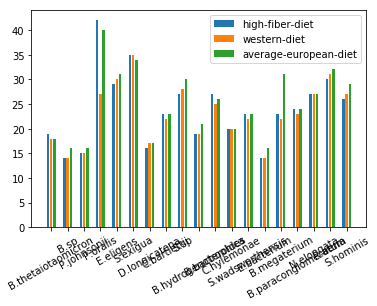

In [27]:
#del stats['Peptostreptococcus_stomatis_DSM_17678']
for s in stats:
    if 'Peptostreptococcus' not in s:
        print(s + '\t' + str(stats[s][types[0]]) + '\t' +  str(stats[s][types[1]]) + '\t' +  str(stats[s][types[2]]))


pos = -0.2
for t in types:
    plotthis = {sp:stats[sp][t] for sp in stats.keys()}
    plt.bar([r + pos for r in range(len(plotthis))], plotthis.values(),width=0.15, align='center', label=t)
    pos +=0.2
plt.xticks(range(len(plotthis)), betternames,rotation=30)
plt.legend()
plt.show()
    